In [0]:
# prerequisites
%reset -f
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import cv2
from matplotlib import pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
bs = 100

# MNIST Dataset
# transform = transforms.Compose([
#     transforms.ToTensor() ,
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.ToTensor()])
    


train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [51]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [52]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [53]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [0]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [0]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

[1/10]: loss_d: 0.245, loss_g: 4.431


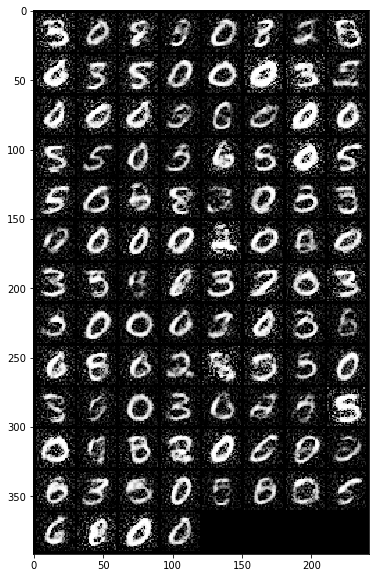

[2/10]: loss_d: 0.238, loss_g: 4.512


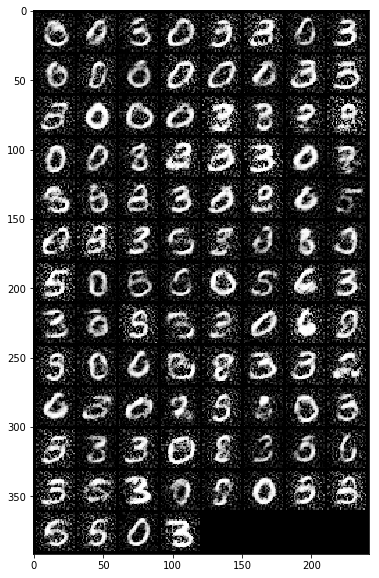

[3/10]: loss_d: 0.247, loss_g: 4.558


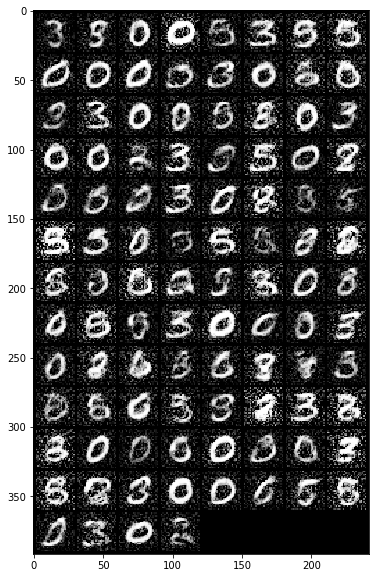

[4/10]: loss_d: 0.240, loss_g: 4.391


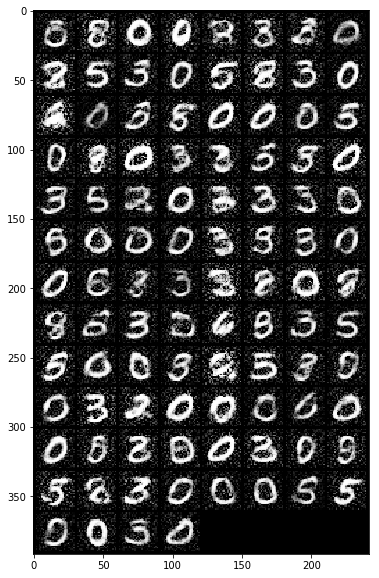

[5/10]: loss_d: 0.247, loss_g: 4.489


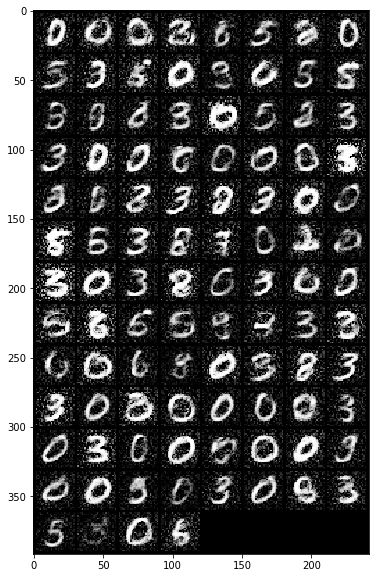

In [0]:
n_epoch = 10
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    with torch.no_grad():
        test_z = torch.randn(bs, z_dim).to(device)
        generated = G(test_z)
        save_image(generated.view(generated.size(0), 1, 28, 28), 'sample'+str(epoch)+ '.png')
        plt.figure(figsize=(20,10))
        f = 'sample'+str(epoch)+'.png'
        a = cv2.imread(f)
        plt.imshow(a)
        plt.show()


In [0]:
for i in range(10):
    with torch.no_grad():
        test_z = torch.randn(bs, z_dim).to(device)
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample'+str(i)+ '.png')

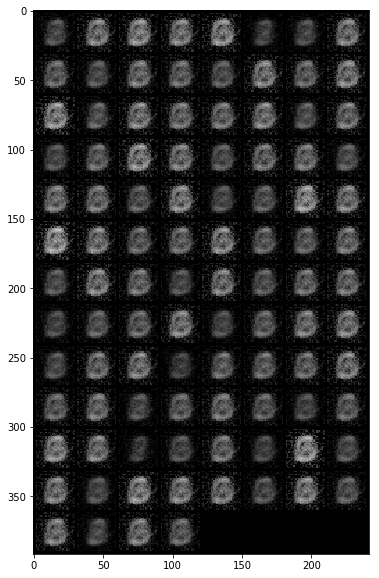

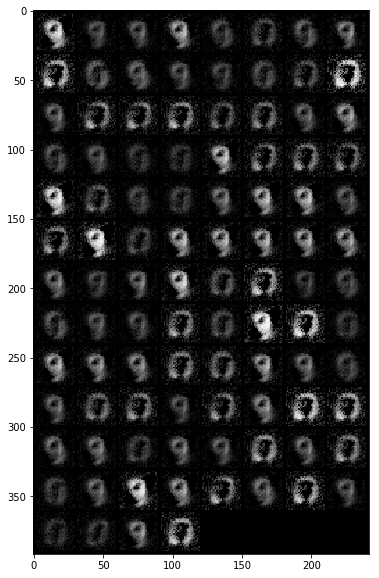

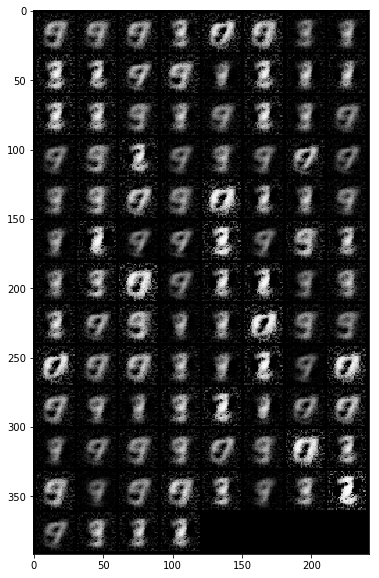

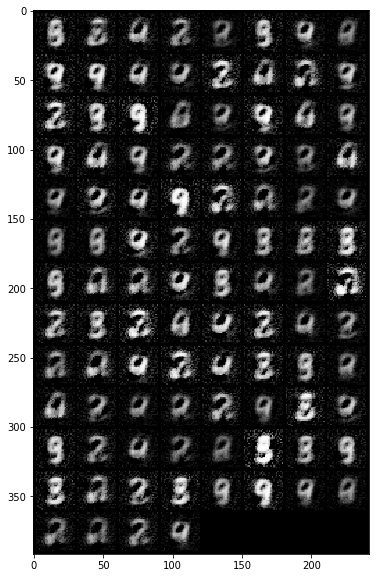

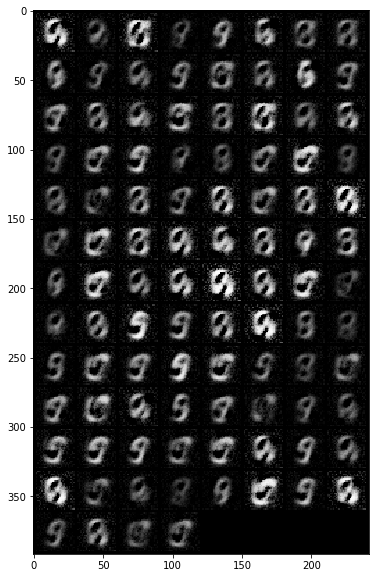

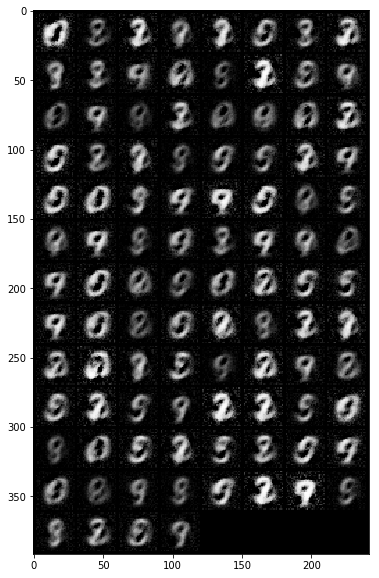

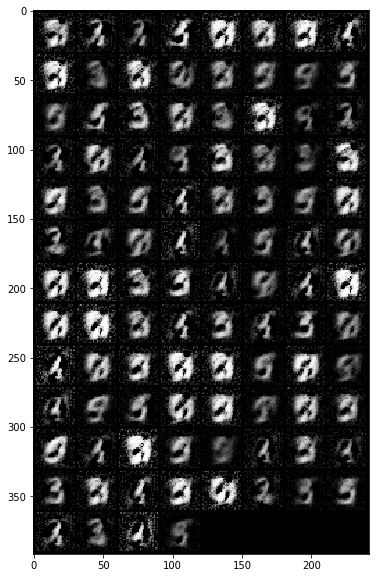

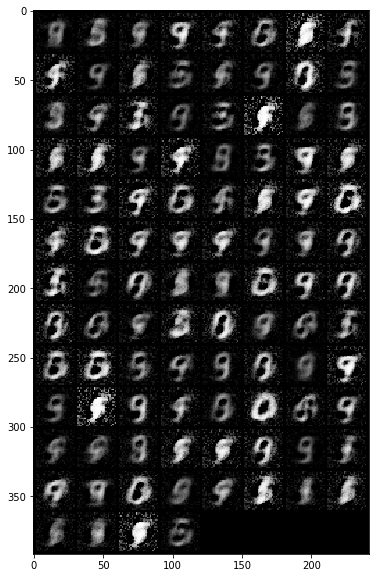

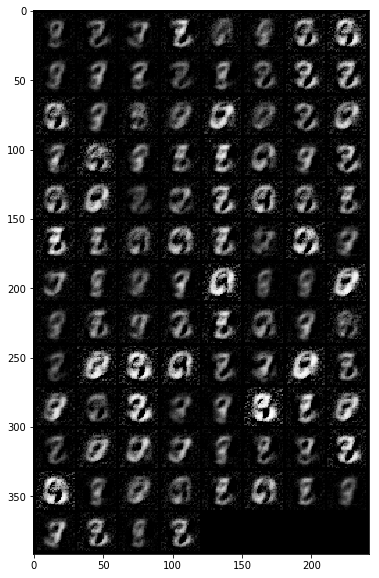

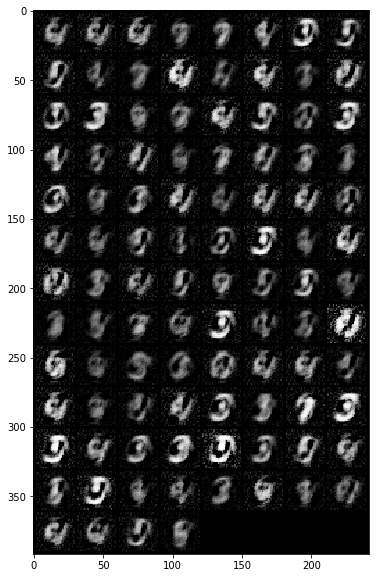

In [75]:
import cv2
from matplotlib import pyplot as plt

for i in range(10):
  plt.figure(figsize=(20,10))
  f = 'sample'+str(i+1)+'.png'
  a = cv2.imread(f)
  plt.imshow(a)
  plt.show()